# Modeling

This notebook aims to build machine learning models to predict rental prices of properties. Four different methods, namely Linear Regression, Decision Trees, Random Forests, and Gradient Boosting will be compared using metrics such as R^2, MAE, and MSE.

## Importing

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import export_graphviz

In [358]:
df = pd.read_csv('../data/processed/clean_kelowna_housing_data.csv')

In [359]:
grouped = df.groupby('Type')
# Group the df by 'Type' column, so I can check for IQR in all types

q1 = grouped["price"].transform(lambda x: x.quantile(0.25))
q3 = grouped["price"].transform(lambda x: x.quantile(0.75))

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)
# Calculate the upper and lower bounds using the interquartile range

outliers = df[df["price"].gt(upper_bound) | df["price"].lt(lower_bound)]

outliers
# print all outliers

,name,price,address,Type,nbeds,nbath,laundry,heating,parking,air_conditioner,furnished,animal_friendly,Area,lat,lng,Walk Score,Bike Score,Transit Score
59,6 beds 2 baths house,7500,"west kelowna, bc",House,6,2,in-unit laundry,central heating,garage parking,central ac,Not specified,No pets,1200,49.85902,-119.58413,6,23,-1
89,6 beds 6 baths house,8000,"west kelowna, bc",House,6,6,in-unit laundry,electric heating,street parking,ac available,unfurnished,No pets,5800,49.85902,-119.58413,6,23,-1
286,4 beds 4 5 baths townhouse,6360,"kelowna, bc",Townhouse,4,4,Not specified,Not specified,Not specified,Not specified,Not specified,No pets,2016,49.88698,-119.49661,64,98,59
423,7 beds 3 baths house,6000,"kelowna, bc, v1x 2j5",House,7,3,in-unit laundry,heating available,parking available,ac available,Not specified,No pets,3200,49.89529,-119.39641,51,83,50
452,4 beds 4 baths house,10800,"kelowna, bc, v1y",House,4,4,in-unit laundry,central heating,garage parking,central ac,unfurnished,No pets,3300,49.88698,-119.49661,64,98,59
711,4 beds 3 baths house,5500,"kelowna, bc, v1p 1a1",House,4,3,laundry in building,central heating,garage parking,central ac,Not specified,dog and cat friendly,2928,49.88056,-119.36212,14,14,24
802,private room for rent,1450,"kelowna, bc, v1y 5n7",Room,1,1,in-unit laundry,gas heating,street parking,central ac,unfurnished,No pets,150,49.87628,-119.48731,52,92,57
803,private room for rent,1450,"kelowna, bc, v1y 5n7",Room,1,1,in-unit laundry,Not specified,Not specified,central ac,unfurnished,dog and cat friendly,150,49.87628,-119.48731,52,92,57
819,4 beds 3 baths house,6600,"west kelowna, bc, v1z 4b7",House,4,3,in-unit laundry,central heating,garage parking,central ac,Not specified,No pets,4000,49.88363,-119.54893,0,6,-1
840,furnished 2 bedroom apt,1500,"peachland, bc",Room,1,1,Not specified,Not specified,Not specified,Not specified,Not specified,No pets,150,49.77387,-119.73592,32,60,-1


In [360]:
df = df.drop(outliers.index)

In [361]:
data = pd.get_dummies(df.drop(columns = {'name', 'address', 'Transit Score'}))
data

,price,nbeds,nbath,Area,lat,lng,Walk Score,Bike Score,Type_Apartment/Condo,Type_House,...,air_conditioner_Not specified,air_conditioner_ac available,air_conditioner_central ac,furnished_Not specified,furnished_furnished,furnished_unfurnished,animal_friendly_No pets,animal_friendly_cat friendly,animal_friendly_dog and cat friendly,animal_friendly_dog friendly
0,3300,3,3,1371,49.87816,-119.47675,54,96,0,0,...,0,0,1,0,0,1,1,0,0,0
1,2000,2,1,914,49.83173,-119.62367,43,49,0,1,...,1,0,0,1,0,0,0,0,1,0
2,570,1,1,150,49.83173,-119.62367,43,49,0,0,...,0,1,0,0,0,1,0,1,0,0
3,2900,3,2,1371,49.83173,-119.62367,43,49,0,0,...,0,0,1,1,0,0,0,0,1,0
4,3800,4,2,2500,49.83173,-119.62367,43,49,0,1,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,950,1,1,1200,49.86395,-119.48816,75,97,0,1,...,0,0,1,1,0,0,1,0,0,0
1259,1100,1,1,150,49.53912,-119.56932,0,28,0,0,...,1,0,0,0,1,0,0,0,1,0
1260,1100,1,1,150,49.84618,-119.60449,14,24,0,0,...,0,0,1,0,1,0,1,0,0,0
1261,2800,2,1,1200,49.90500,-119.46058,15,52,0,1,...,1,0,0,0,0,1,1,0,0,0


In [362]:
X = data[['nbeds', 'Area', 'Type_Apartment/Condo', 'nbath', 'Bike Score', 'Walk Score', 'lng', 'lat', 'laundry_in-unit laundry', 'heating_central heating']]  # all rows, no label
#X = data.iloc[:, 1:]
y = data.loc[:, 'price']  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'Area', 'Bike Score', 'lng', 'lat', 'nbeds', 'Walk Score', 'laundry in unit', 'nbath', 'heating central', 'condo'

## Linear regression

In [363]:
# Fit multiple linear regression model to training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict rental prices on testing data
y_pred = model.predict(X_test)

# Evaluate performance of model
lr_r2 = r2_score(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)

print('R^2 in linear regression:', lr_r2)
print('MSE in linear regression:', lr_mse)
print('MAE in linear regression:', lr_mae)

R^2 in linear regression: 0.7356026563139852
MSE in linear regression: 214739.77763556223
MAE in linear regression: 316.66984197462625


In [364]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error', shuffle = False)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -test_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 79     148294.969789
258    193589.056893
436    205718.361537
615    216087.814199
794    225920.719340
dtype: float64

 --------------------

Mean validation scores

 79     274670.449001
258    248078.959770
436    238079.196758
615    235626.920959
794    234356.383438
dtype: float64


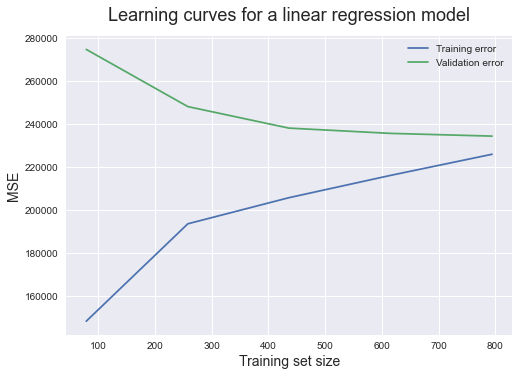

In [365]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

Almost converged, so we have to look for more complex model.

In [366]:
train_scores_mean

array([148294.9697887 , 193589.05689275, 205718.36153742, 216087.81419907,
       225920.71933981])

In [423]:
validation_scores_mean

array([258238.47000089, 249453.28448623, 247459.28157982, 238049.06899909,
       232277.8636871 ])

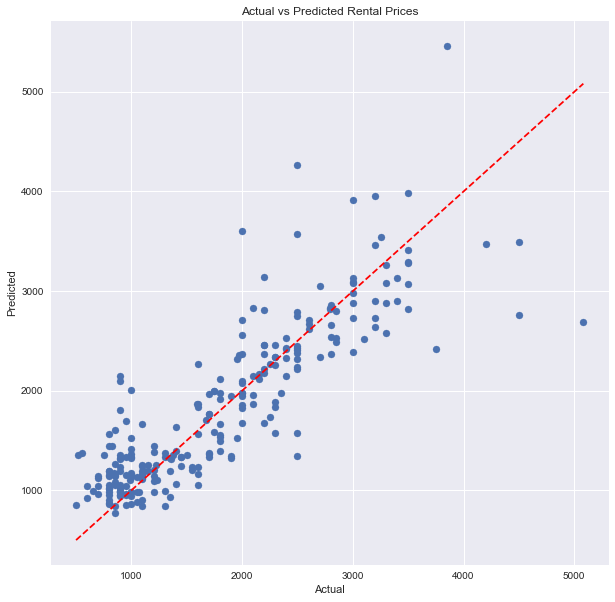

In [368]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Rental Prices')
plt.show()

## Decision trees

In [411]:
# Fit decision trees model to training data
tree_model = DecisionTreeRegressor(random_state=46, ccp_alpha = 0.001)

# Define the parameter grid for pruning
param_grid = {
    'max_depth': [2, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_leaf_nodes': [5, 10, 13, 15],
    'min_samples_split': [3, 5, 7],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Predict rental prices on testing data
y_pred = grid_search.best_estimator_.predict(X_test)

dt_r2 = r2_score(y_test, y_pred)
dt_mse = mean_squared_error(y_test, y_pred)
dt_mae = mean_absolute_error(y_test, y_pred)
print("Rˆ2 in decision trees:", dt_r2)
print("MSE in decision trees:", dt_mse)
print("MAE in decision trees:", dt_mae)

Rˆ2 in decision trees: 0.7719954902121474
MSE in decision trees: 185182.0334091301
MAE in decision trees: 295.77507403546383


In [370]:
grid_search.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=4, max_leaf_nodes=15,
                      min_samples_leaf=3, min_samples_split=3, random_state=46)

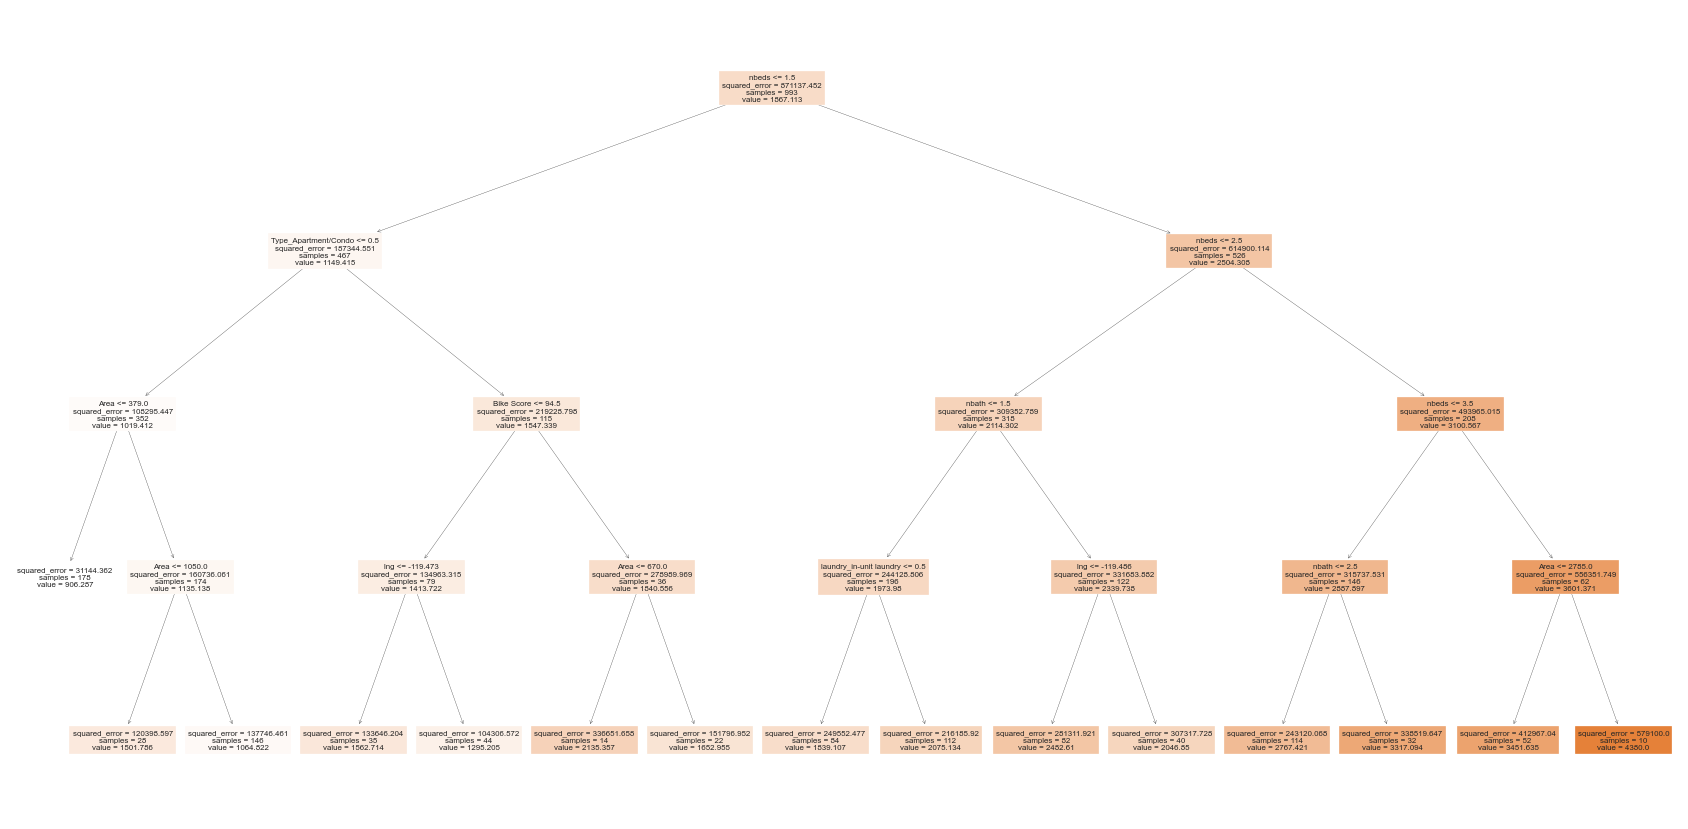

In [371]:
# Plot decision tree
plt.figure(figsize=(30,15))
plot_tree(grid_search.best_estimator_, feature_names=X.columns, filled=True)
plt.show()

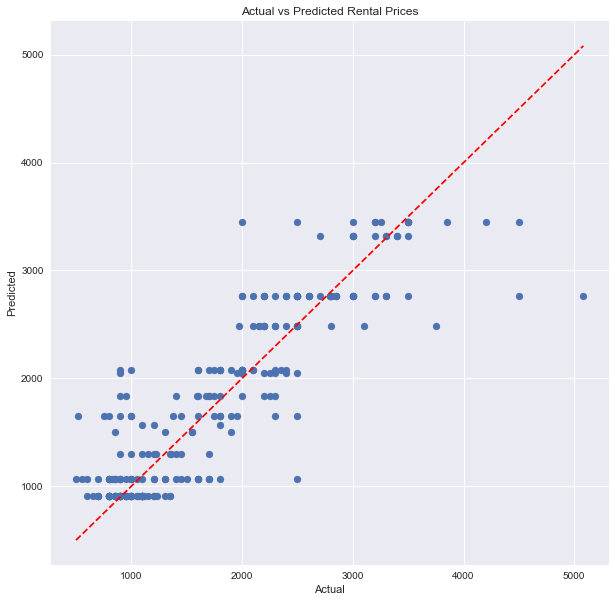

In [372]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Rental Prices')
plt.show()

In [434]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Replace 'model' with the name of your model
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=10, scoring = 'neg_mean_squared_error', shuffle = True)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -test_scores.mean(axis=1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(validation_scores_mean, index=train_sizes))


Mean training scores

 89      85623.082524
290    116577.062013
491    138002.346206
692    144580.104950
893    151240.713682
dtype: float64

 --------------------

Mean validation scores

 89     268437.618536
290    240540.984679
491    216369.948952
692    210713.765406
893    207214.541505
dtype: float64


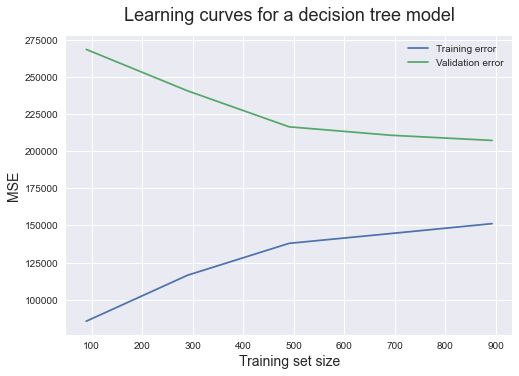

In [435]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a decision tree model', fontsize = 18, y = 1.03)
plt.legend()

## Random Forest

In [429]:
# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for pruning
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
}

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rf_reg = grid_search.best_estimator_

# Train the model on the training set using the best hyperparameters
best_rf_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_reg.predict(X_test)

rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)

print("Rˆ2 in random forest:", rf_r2)
print("MSE in random forest:", rf_mse)
print("MAE in random forest:", rf_mae)

Rˆ2 in random forest: 0.788561260837054
MSE in random forest: 171727.5491440435
MAE in random forest: 284.4151697399289


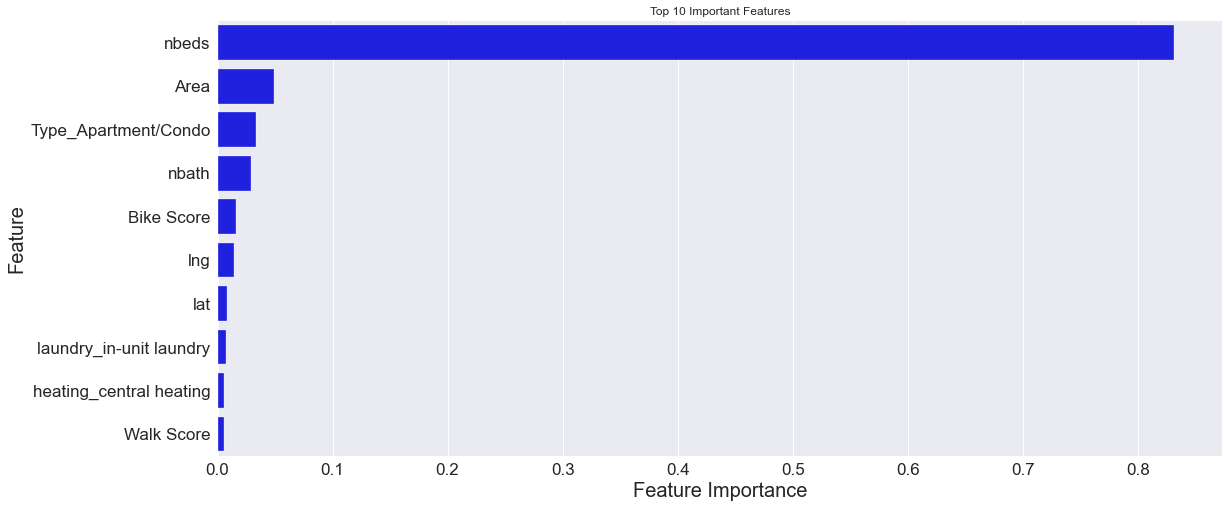

In [428]:
# Get feature importances from the best random forest model
importances = best_rf_reg.feature_importances_

# Get the names of the features
feature_names = X_train.columns.tolist()

# Create a dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Plot the feature importances as a bar chart
plt.figure(figsize=(18, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df[0:10], color='b')
plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Top 10 Important Features')
plt.show()

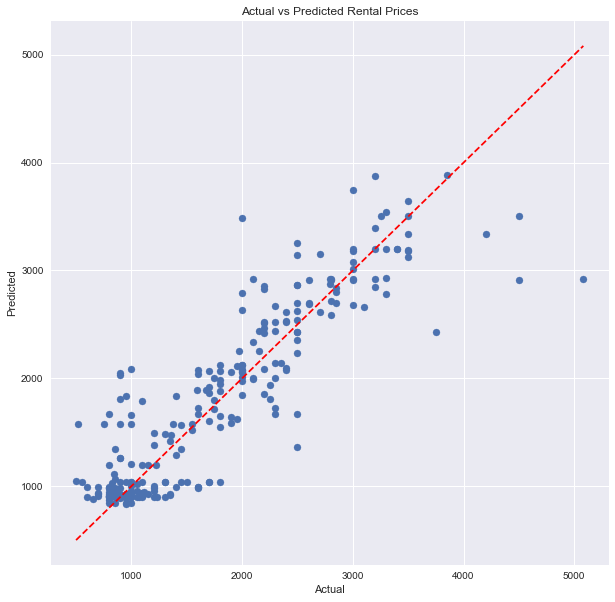

In [416]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Rental Prices')
plt.show()

In [426]:
model

RandomForestRegressor(random_state=42)

In [432]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Replace 'model' with the name of your model
train_sizes, train_scores, test_scores = learning_curve(best_rf_reg, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error', shuffle = True)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -test_scores.mean(axis=1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(validation_scores_mean, index=train_sizes))


Mean training scores

 79      83846.257032
258    113203.464131
436    133222.944917
615    144125.199748
794    148513.513909
dtype: float64

 --------------------

Mean validation scores

 79     259484.157894
258    216459.015296
436    211058.609102
615    207670.678172
794    207338.321710
dtype: float64


In [425]:
validation_scores_mean

array([258238.47000089, 249453.28448623, 247459.28157982, 238049.06899909,
       232277.8636871 ])

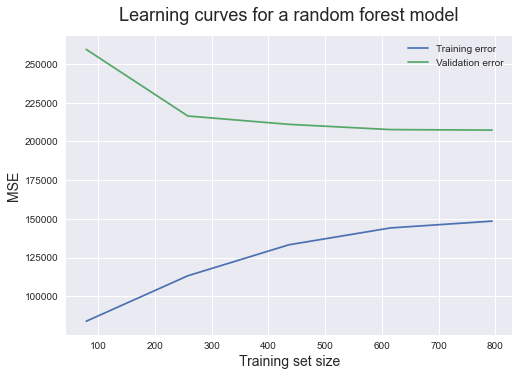

In [433]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a random forest model', fontsize = 18, y = 1.03)
plt.legend()

## Gradient boosting

In [491]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# define the hyperparameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 3,
    'n_jobs': -1
}
evals_result = {}

# create the training and validation datasets for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# train the XGBoost model
xgb_model = xgb.train(params,
                      dtrain,
                      num_boost_round=5000,
                      evals=[(dtrain, 'train'), (dval, 'val')],
                      early_stopping_rounds=10,
                      verbose_eval=10,
                      evals_result=evals_result)


# predict the target values for the test data
y_pred = xgb_model.predict(dval)

# calculate the mean squared error and R^2 score
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)

# print the results
print('Mean squared error: {:.4f}'.format(xgb_mse))
print('R^2 score: {:.4f}'.format(xgb_r2))
print('MAE: {:.4f}'.format(xgb_mae))

[0]	train-rmse:1989.24352	val-rmse:1905.91298
[10]	train-rmse:1253.42042	val-rmse:1175.72952
[20]	train-rmse:827.44065	val-rmse:766.32450
[30]	train-rmse:590.08838	val-rmse:548.82502
[40]	train-rmse:466.06796	val-rmse:450.68375
[50]	train-rmse:403.49752	val-rmse:414.41573
[60]	train-rmse:369.77375	val-rmse:403.81186
[70]	train-rmse:350.39060	val-rmse:402.21687
[76]	train-rmse:342.11721	val-rmse:402.70635
Mean squared error: 162172.4028
R^2 score: 0.8003
MAE: 271.5177


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

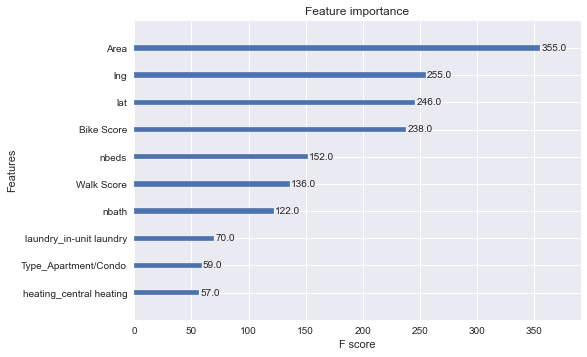

In [467]:
xgb.plot_importance(xgb_model)

<AxesSubplot:>

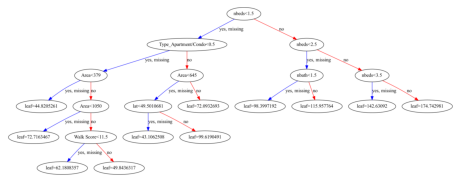

In [468]:
xgb.plot_tree(xgb_model)

In [482]:
xgb_model.evals_result()

AttributeError: 'Booster' object has no attribute 'evals_result'

In [506]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# define the hyperparameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 3,
    'n_jobs': -1
}
evals_result = {}

# create the training and validation datasets for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# create and train the XGBoost regressor model
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10,
              eval_metric=['rmse'], verbose=10)

# predict the target values for the test data
y_pred = xgb_model.predict(X_test)

# calculate the mean squared error and R^2 score
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)

# print the results
print('Mean squared error: {:.4f}'.format(xgb_mse))
print('R^2 score: {:.4f}'.format(xgb_r2))
print('MAE: {:.4f}'.format(xgb_mae))

[0]	validation_0-rmse:1989.24352	validation_1-rmse:1905.91298
[10]	validation_0-rmse:1253.42042	validation_1-rmse:1175.72952
[20]	validation_0-rmse:827.44065	validation_1-rmse:766.32450
[30]	validation_0-rmse:590.08838	validation_1-rmse:548.82502
[40]	validation_0-rmse:466.06796	validation_1-rmse:450.68375


/Users/allienn/.conda/envs/workspace/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/allienn/.conda/envs/workspace/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:403.49752	validation_1-rmse:414.41573
[60]	validation_0-rmse:369.77375	validation_1-rmse:403.81186
[70]	validation_0-rmse:350.39060	validation_1-rmse:402.21687
[76]	validation_0-rmse:342.11721	validation_1-rmse:402.70635
Mean squared error: 161316.5733
R^2 score: 0.8014
MAE: 271.1976


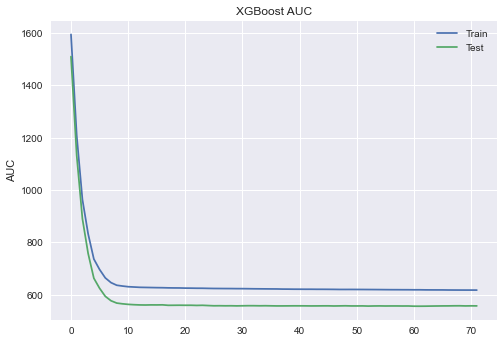

In [504]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

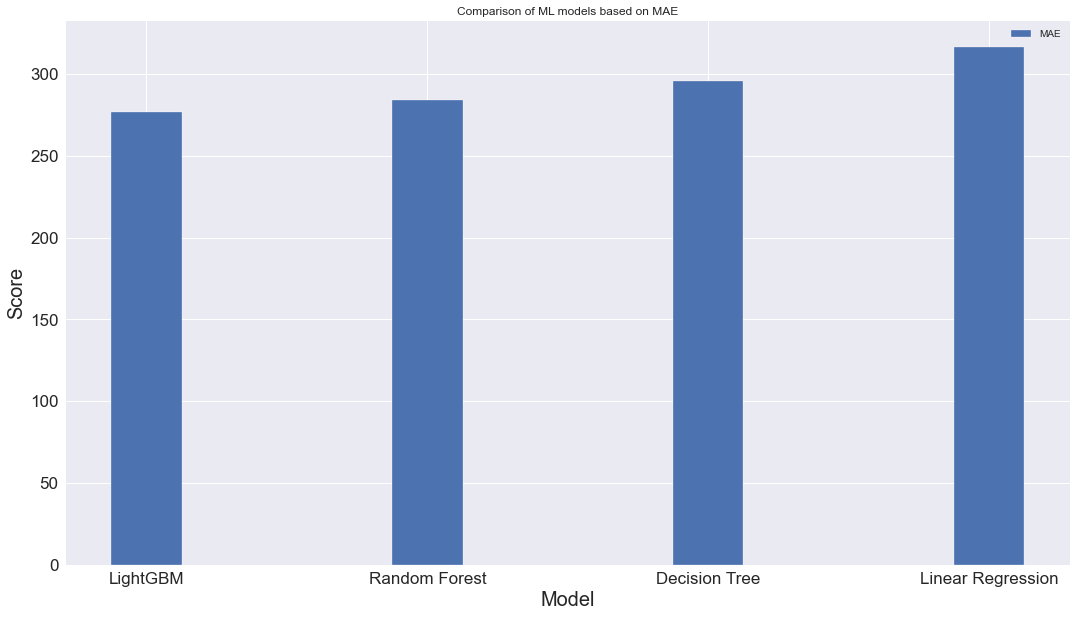

In [403]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18, 10))

# Define the model names and their respective evaluation metrics
models = ['LightGBM', 'Random Forest', 'Decision Tree', 'Linear Regression']
mae_scores = [lgb_mae, rf_mae, dt_mae, lr_mae]

# Set the width of the bars
barWidth = 0.25

# Set the x positions of the bars
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar chart
plt.bar(r2, mae_scores, width=barWidth, edgecolor='white', label='MAE')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add legend and labels
plt.legend()
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Comparison of ML models based on MAE')
plt.show()

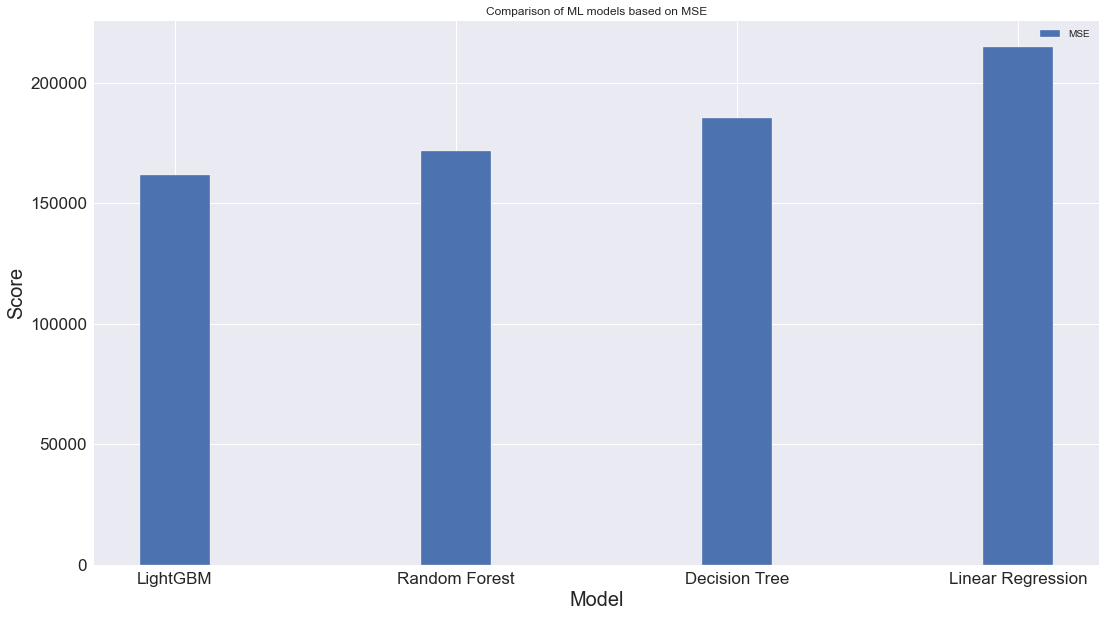

In [402]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18, 10))

# Define the model names and their respective evaluation metrics
models = ['LightGBM', 'Random Forest', 'Decision Tree', 'Linear Regression']
mse_scores = [lgb_mse, rf_mse, dt_mse, lr_mse]

# Set the width of the bars
barWidth = 0.25

# Set the x positions of the bars
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar chart
plt.bar(r2, mse_scores, width=barWidth, edgecolor='white', label='MSE')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add legend and labels
plt.legend()
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Comparison of ML models based on MSE')
plt.show()

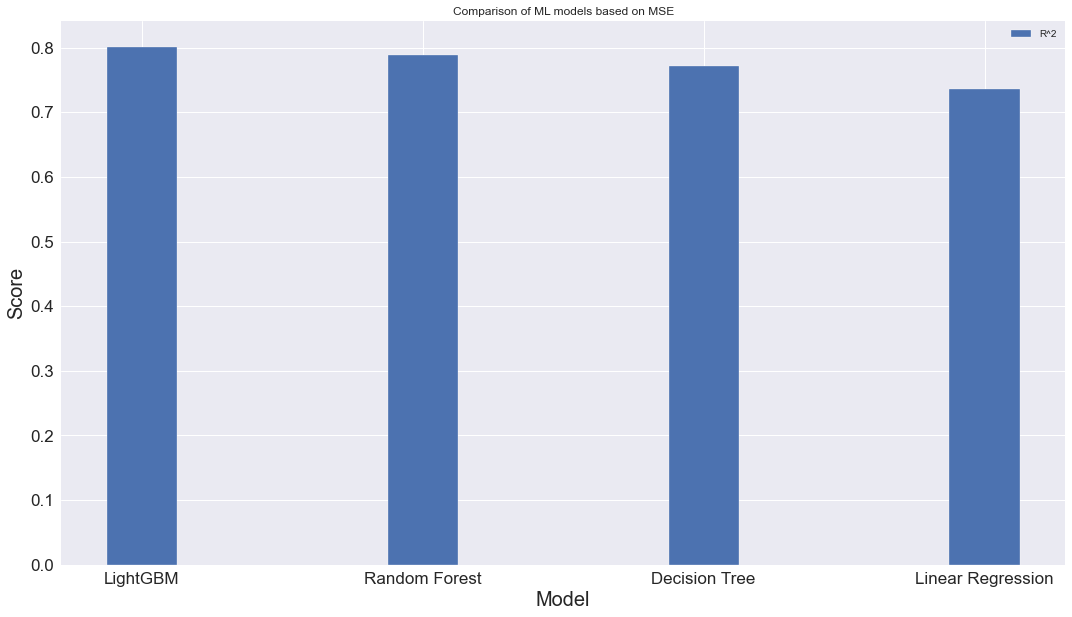

In [401]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18, 10))

# Define the model names and their respective evaluation metrics
models = ['LightGBM', 'Random Forest', 'Decision Tree', 'Linear Regression']
mse_scores = [lgb_r2, rf_r2, dt_r2, lr_r2]

# Set the width of the bars
barWidth = 0.25

# Set the x positions of the bars
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar chart
plt.bar(r2, mse_scores, width=barWidth, edgecolor='white', label='R^2')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add legend and labels
plt.legend()
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Comparison of ML models based on MSE')
plt.show()